In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from datetime import datetime
from matplotlib import pyplot as plt

import seaborn as sns

#import tensorrt
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, Dense

from tensorflow.keras.optimizers import Adam, Nadam, AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
def mase(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    
    return mae_model / mae_naive if mae_naive != 0 else float('inf')



def printRegressionMetrics(y_true, y_pred):
    
    MAPE = metrics.mean_absolute_percentage_error(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    MASE = mase(y_true, y_pred)
    
    print('MSE:')
    print(MSE)
    print('MAPE:')
    print(MAPE)
    print('MASE:')
    print(MASE)
    print('R2:')
    print(R2)

NEW_MODEL = True
MODEL_NAME = 'MickaNet-LSTM-V2'

In [16]:
WINDOW_SIZE = 24
x_frames = []
y_frames = []

In [17]:
data = pd.read_csv("./Dataset/dataOld.csv")
data = data.head(25000)

In [18]:
teste = data.copy()
teste["timestamp"] = teste["timestamp"] / 1000
teste["timestamp"] = teste['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
teste.reset_index(drop=True, inplace=True)

In [19]:
scaler_price = MinMaxScaler(feature_range=(0,1))
scaler_volume= MinMaxScaler(feature_range=(0,1))
scaler_trades = MinMaxScaler(feature_range=(0,1))

price_scaled = np.array(teste["price"]).copy()
volume_scaled = np.array(teste["volume"]).copy()
trades_scaled = np.array(teste["trades"]).copy()


teste['price'] = scaler_price.fit_transform(price_scaled.reshape(-1,1)).flatten()
teste['volume'] = scaler_volume.fit_transform(volume_scaled.reshape(-1,1)).flatten()
teste['trades'] = scaler_trades.fit_transform(trades_scaled.reshape(-1,1)).flatten()

In [20]:
teste = teste.set_index('timestamp')
teste

,volume,trades,price
timestamp,,,
2020-01-01 00:00:00,0.009178,0.015846,0.391867
2020-01-01 00:15:00,0.005096,0.009680,0.392880
2020-01-01 00:30:00,0.006455,0.011474,0.391020
2020-01-01 00:45:00,0.003912,0.006773,0.391458
2020-01-01 01:00:00,0.004412,0.010274,0.390765
...,...,...,...
2020-09-17 08:45:00,0.035172,0.059518,0.819201
2020-09-17 09:00:00,0.026115,0.054485,0.817022
2020-09-17 09:15:00,0.039881,0.059079,0.813955


In [21]:
teste.reset_index(drop=True, inplace=True)
teste

,volume,trades,price
0,0.009178,0.015846,0.391867
1,0.005096,0.009680,0.392880
2,0.006455,0.011474,0.391020
3,0.003912,0.006773,0.391458
4,0.004412,0.010274,0.390765
...,...,...,...
24995,0.035172,0.059518,0.819201
24996,0.026115,0.054485,0.817022
24997,0.039881,0.059079,0.813955
24998,0.034600,0.059787,0.815495


In [22]:
x_names = teste.columns.to_list()

# Extraia os dados uma única vez para evitar chamadas repetidas a .loc
x_data = teste[x_names].to_numpy()
y_data = teste['price'].to_numpy()

# Número de amostras possíveis
num_samples = len(teste) - WINDOW_SIZE

# Pré-alocação das matrizes para otimizar a memória
x_frames = np.zeros((num_samples, WINDOW_SIZE, len(x_names)))  # Forma 3D para frames de entrada
y_frames = np.zeros((num_samples, 1))  # Vetor de saída

# Preenchendo as matrizes
for i in range(num_samples):
    x_frames[i] = x_data[i:i+WINDOW_SIZE]  # Janela deslizante de dados de entrada
    y_frames[i] = y_data[i+WINDOW_SIZE] 

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_frames, y_frames, test_size=0.3, shuffle=False)

In [24]:
#Nurons in each layer
units_lstm1 = 32
units_lstm2 = 64
units_lstm3 = 64
units_dense = 32

#Constants
ACT_FUNC = "tanh"

#inicializador
initializer = tensorflow.keras.initializers.LecunNormal(seed=42)

# Criação das entradas de treino+validação
inputs = Input(shape=(x_frames.shape[1], x_frames.shape[2]), name="x_train")

# Camada LSTM 1
layer_lstm1 = LSTM(units_lstm1, 
                     activation=ACT_FUNC, 
                     return_sequences=True,
                     kernel_initializer=initializer)(inputs)

# Camada LSTM 2
layer_lstm2 = LSTM(units_lstm2, 
                     activation=ACT_FUNC, 
                     return_sequences=True,
                     kernel_initializer=initializer)(layer_lstm1)

# Camada LSTM 3
layer_lstm3 = LSTM(units_lstm3,
                     activation=ACT_FUNC, 
                     return_sequences=False,
                     kernel_initializer=initializer)(layer_lstm2)

# Camada densa final para ajustar o formato da saída
layer_dense = Dense(units_dense, activation=ACT_FUNC)(layer_lstm3)

# Camada densa final para ajustar o formato da saída
layer_dense_out = Dense(y_frames.shape[1], activation=ACT_FUNC)(layer_dense)

# Criação do modelo
model_trained = Model(inputs=inputs, outputs=layer_dense_out)


In [25]:
model_trained.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_train (InputLayer)            │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,577 (252.25 KB)

 Trainable params: 64,577 (252.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
if (NEW_MODEL == True):
          
    es = EarlyStopping(monitor='loss', mode='min', patience=50)


    cp = ModelCheckpoint(filepath=f'models/{MODEL_NAME}.weights.h5', 
                           save_weights_only=True, 
                           monitor='loss', 
                           mode='min', 
                           save_best_only=True)
    
    #Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, clipnorm=1)
    #Nadam(learning_rate=0.0001, beta_1=0.85, beta_2=0.989, epsilon=1e-06, clipnorm=1)
    
    opt = Nadam(learning_rate=0.0001, beta_1=0.85, beta_2=0.989, epsilon=1e-06, clipnorm=1)
    
    model_trained.compile(optimizer = opt, loss = 'mean_squared_error')

    history = model_trained.fit(x_train, 
                               y_train, 
                               validation_split=0.2, 
                               epochs=1000, 
                               verbose=1, 
                               callbacks=[cp, es], 
                               batch_size=128, 
                               shuffle=False)
    
    np.save('models/history_model.npy', history.history)
    model_trained.load_weights(f'models/{MODEL_NAME}.weights.h5')
    model_trained.save(f'models/{MODEL_NAME}.keras')
else:
    model_trained = load_model(f'models/{MODEL_NAME}.keras')

Epoch 1/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.8309e-04 - val_loss: 1.9363e-04
Epoch 2/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.0163e-04 - val_loss: 1.4588e-04
Epoch 3/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.6005e-04 - val_loss: 3.3059e-04
Epoch 4/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1.5267e-04 - val_loss: 4.1889e-04
Epoch 5/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.4574e-04 - val_loss: 4.7575e-04
Epoch 6/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.5273e-04 - val_loss: 5.7242e-04
Epoch 7/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.6615e-04 - val_loss: 5.1538e-04
Epoch 8/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1.5669e-04 - val_loss: 4.7103e-04
Epoch 9/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.5204e-04 - val_loss: 4.6130e-04
Epoch 10/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.5421e-04 - val_loss: 4.1687e-04
Epoch 11/1000
110/110 ━━━━━━━

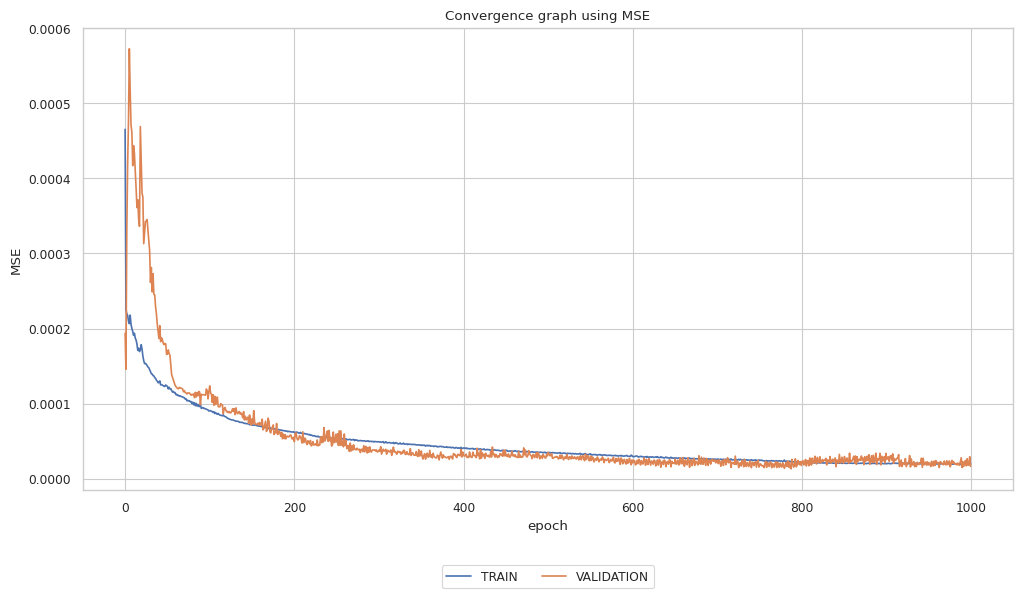

In [27]:
history=np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'mse'

fig = plt.figure()

plt.plot(train_metric, label='TRAIN'), 
plt.plot(valid_metric, label='VALIDATION')
plt.ylabel(name_metric.upper())
plt.xlabel('epoch')
plt.title('Convergence graph using ' + name_metric.upper())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

In [28]:
y_hat = model_trained.predict(x_test)

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [29]:
y_train2 = scaler_price.inverse_transform(y_train.flatten().reshape(-1, 1))
y_test2 = scaler_price.inverse_transform(y_test.flatten().reshape(-1, 1))
y_hat2 = scaler_price.inverse_transform(y_hat.flatten().reshape(-1, 1))

In [30]:
print(y_test2 - y_hat2)

[[  2.3615625 ]
 [ 35.17433594]
 [ 30.97027344]
 ...
 [ 87.32851563]
 [122.98242188]
 [ 69.0125    ]]


In [31]:
y_test2 - y_hat2

array([[  2.3615625 ],
       [ 35.17433594],
       [ 30.97027344],
       ...,
       [ 87.32851563],
       [122.98242188],
       [ 69.0125    ]])

In [32]:
y_hat2

array([[ 9221.648 ],
       [ 9212.556 ],
       [ 9232.97  ],
       ...,
       [10745.521 ],
       [10723.018 ],
       [10734.9375]], dtype=float32)

In [33]:
y_test2

array([[ 9224.01],
       [ 9247.73],
       [ 9263.94],
       ...,
       [10832.85],
       [10846.  ],
       [10803.95]])

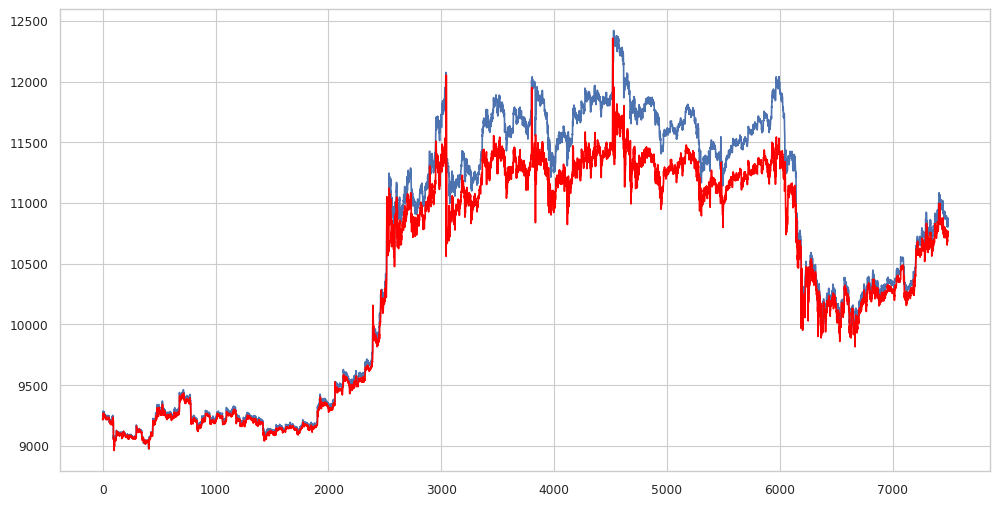

In [34]:
plt.plot(y_test2)
plt.plot(y_hat2, color='red')

In [35]:
#cria um data table com os valores reais e preditos
df_forecast = pd.DataFrame()
df_forecast['y_hat'] = np.hstack((y_train2.flatten(), y_hat2.flatten()))
df_forecast['y_true'] = np.hstack((y_train2.flatten(), y_test2.flatten()))

df_forecast.shape

(24976, 2)

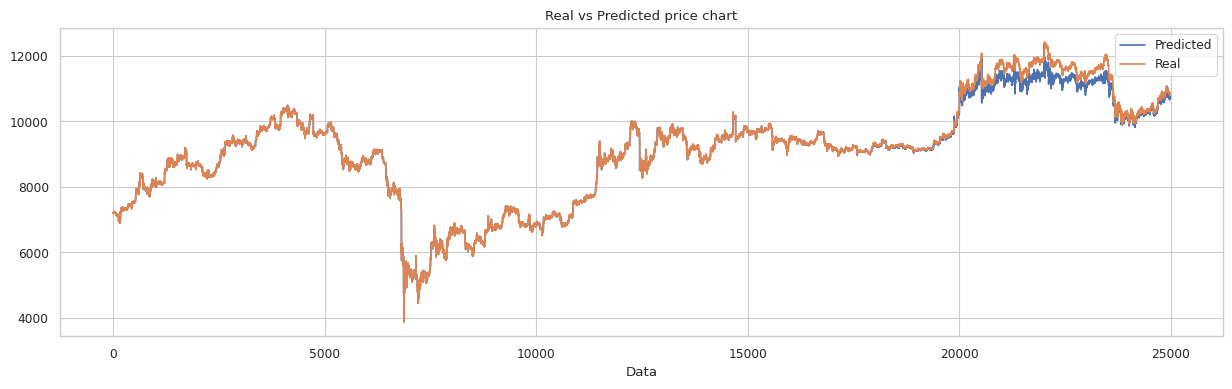

In [36]:
sns.set_theme(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Predicted", "Real"])
ax.set_title("Real vs Predicted price chart")

plt.grid(True)

plt.show()

plt.close()

In [37]:
printRegressionMetrics(y_test2, y_hat2)

MSE:
67913.19003071089
MAPE:
0.01665803791456852
MASE:
10.998157451624287
R2:
0.9381277003126455
